# **Assignment 3**


### **Relevant lecture slides: https://moodle.idc.ac.il/2021/mod/resource/view.php?id=61766**

<br>


# **Instructions**

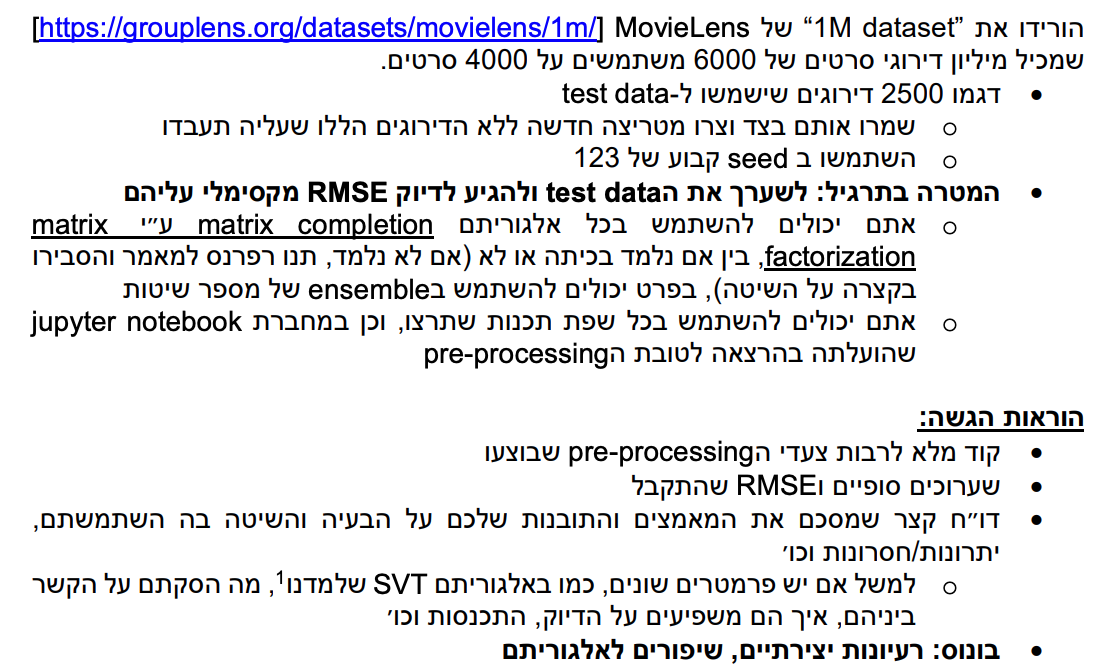

In [7]:
import sys
!{sys.executable} -m pip install -r requirements.txt

# Preprocessing

In [1]:
import shutil, os, random
from pathlib import Path
from urllib.request import urlopen
from zipfile import ZipFile
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# from numpy import linalg as la
import pandas as pd
from scipy.sparse.linalg import norm
import scipy.sparse as ss
# import scipy.io
from scipy.sparse.linalg import svds
from tqdm.notebook import tqdm

# from sklearn.model_selection import train_test_split
# from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse

In [2]:
def rmse(y_true, y_pred):
    return mse(y_true, y_pred, squared=False)

In [17]:
def get_dataset():
    path = Path("m1.zip")
    if not path.exists():
        with path.open("wb") as f:
            print("Downloading dataset...")
            f.write(urlopen("http://files.grouplens.org/datasets/movielens/ml-1m.zip").read())
    if not Path("ml-1m").is_dir():
        with ZipFile("m1.zip") as zf:
            zf.extractall()
    ratings_list = [i.strip().split("::") for i in open('ml-1m/ratings.dat', 'r').readlines()]
    ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
    ratings_df['Rating'] = ratings_df['Rating'].apply(pd.to_numeric)    
    return ratings_df

ratings_df = get_dataset()
ratings_df.head()

In [36]:
SEED = 123
random.seed(SEED)

In [19]:
print("#users: " + str(ratings_df.UserID.nunique()))
print("#movies: " + str(ratings_df.MovieID.nunique()))
print("#ratings %: "+ str(ratings_df.shape[0] /\
                          (ratings_df.UserID.nunique()*ratings_df.MovieID.nunique()) * 100))

#users: 6040
#movies: 3706
#ratings %: 4.468362562231285


In [20]:
ratings_df.Rating.describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

pivot ratings_df to get user-rating matrix format

In [21]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


de-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [22]:
#R = R_df.as_matrix()
R = R_df.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

# Sample test data

create test data by sampling (and removing) 2,500 ratings

In [23]:
rated_indices = np.argwhere(R_demeaned>0)

In [24]:
test_set = random.sample(list(rated_indices), 2500)

In [25]:
print("1st index is "+str(test_set[0])+ " and its rating is "+str(R_demeaned[test_set[0][0], test_set[0][1]]))

1st index is [ 296 3087] and its rating is 4.705342687533729


In [26]:
test_ratings = []
for i in range(len(test_set)):
    test_ratings.append(R_demeaned[test_set[i][0],test_set[i][1]])
    R_demeaned[test_set[i][0], test_set[i][1]] = 0

In [27]:
print("1st index is " + str(test_set[0]) + " and its rating is " + str(R_demeaned[test_set[0][0], test_set[0][1]]))

1st index is [ 296 3087] and its rating is 0.0


# Singular Value Decomposition

Scipy function svds allow to choose the number of latent factors

In [28]:
U, sigma, Vt = svds(R_demeaned, k = 50)

convert it to the diagonal matrix form.

In [29]:
sigma = np.diag(sigma)

# Making Predictions from the Decomposed Matrices

can predict by simply multiplying the matrices to get the rank k=50 approximation of the ratings matrix.
(also need to add the user means back)

In [30]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(predicted_ratings, columns = R_df.columns)

In [31]:
pred_set = [max(predicted_ratings[x[0], x[1]],0) for x in test_set]

In [32]:
res_df = pd.DataFrame()

res_df["act"]=test_ratings
res_df["pred"]=pred_set
res_df.head(10)

,act,pred
0,4.705343,2.292930
1,2.844307,1.660000
2,0.058824,0.720654
3,4.817323,1.135902
4,1.869401,0.222807
5,3.722612,2.738209
6,1.586346,1.827266
7,4.871560,1.795515
8,2.588505,2.599185
9,0.942256,0.350657


finally, let's evaluate the RMSE:

In [33]:
np.sqrt(mse(test_ratings, pred_set))

2.196816569497359

# SVT

In [46]:
def get_train_set(data, indices):
    data = data.copy()
    data[indices[:,0],indices[:,1]] = 0
    return data

def normalize(data, mean):
    return data

def denormalize(data, mean):
    return data

def rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_pred-y_true)**2))

In [34]:
# def SVT(M, iterations, func, tau, delta, debug=True):
#     Omega = M.nonzero()
#     tol = 0.001
#     incre = 5
    
#     # SVT
#     r = 0
#     P_Omega_M = ss.csr_matrix((np.ravel(M[Omega]), Omega), shape=M.shape)
#     normProjM = norm(P_Omega_M)
#     k0 = np.ceil(tau / (delta * normProjM))
#     Y = k0 * delta * P_Omega_M
    
#     bar = tqdm(range(iterations))
    
#     rmses = []
#     for k in bar:
#         s = r + 1
#         sparse_Y = ss.csc_matrix(Y)
#         u1, s1, v1 = sparsesvd(sparse_Y, s)
#         while np.min(s1) > tau and s >= min(*M.shape):
#             u1, s1, v1 = sparsesvd(sparse_Y, s)
#             s+=incre
        
#         r = np.sum(s1 > tau)
#         U = u1.T[:, :r]
#         V = v1[:r, :]
#         S = s1[:r] - tau
#         x = (U * S).dot(V)
        
#         x_omega = ss.csr_matrix((x[Omega], Omega), shape=M.shape)

#         reconstrcution_loss = norm(x_omega - P_Omega_M) / norm(P_Omega_M)
#         if reconstrcution_loss < tol:
#             break

#         diff = P_Omega_M - x_omega
#         Y += delta * diff

#         if k%5==0:
#             rmse_current = rmse(M[Omega], x[Omega])
#             test_rmse = func(x)
#             print('Iter %d , RMSE %.3f RMSE %.3f on test' % (k, rmse_current, test_rmse))
#             rmses.append(rmses)
#     return x, rmses

# test_true = R_df.values[test_indices[:,0],test_indices[:,1]]
# func = lambda X: rmse(np.clip(denormalize(X, user_ratings_mean)[test_indices[:,0],test_indices[:,1]], 1, 5), test_true)

# taus = [20000, 15000, 23000]
# deltas = [1.8, 2, 5]


# best = float('inf')
# best_model= None
# best_rmses = []

# results = []
# for tau, delta in itertools.product(taus,deltas):
#     print(tau, delta)
#     M, rmses  = SVT(train_set, 250, func, tau, delta), user_ratings_mean
#     model = np.clip(denormalize(M), 1,5)
#     test_pred = model[test_indices[:,0],test_indices[:,1]]
#     score = rmse(test_pred, test_true)
#     if score<best:
#         best = score
#         best_model = model
#         best_rmses = rmses
#     results.append({'tau': tau, 'delta': delta, 'rmse_test':score})
#     print(results[-1])

# test_pred = best_model[test_indices[:,0],test_indices[:,1]]

# sample_pred_df = pd.DataFrame({'test_pred': test_pred.ravel(), 'test_true': test_true.ravel()})
# print(sample_pred_df.head(10))

In [37]:
# PREPARE DATA FOR FUNK

user_ratings_mean = np.mean(R_df.values, axis = 1).reshape(-1,1)
R_demeaned = normalize(R_df.values, user_ratings_mean)

#split
np.random.seed(SEED)
random.seed(SEED)
test_indices = np.array(random.sample(list(np.argwhere(R_df.values>0)), 2500))
train_set = get_train_set(R_demeaned, test_indices)
train_set[R_df.values == 0] = 0

# Funk-SVD

In [47]:
!{sys.executable} -m pip install -q -q git+https://github.com/gbolmier/funk-svd

In [48]:
from funk_svd.dataset import fetch_ml_ratings
from funk_svd import SVD
import random, os
import numpy as np

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
seed_everything()

In [49]:
ratings_df = get_dataset()
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)

In [50]:
np.random.seed(SEED)
random.seed(SEED)
test_indices = np.array(random.sample(list(np.argwhere(R_df.values>0)), 2500))

In [51]:
df = fetch_ml_ratings(variant='1m')

def split(df, R_df, test_indices):
    x_indices = test_indices[:,0]
    y_indices = test_indices[:,1]
    u_ids = R_df.index[x_indices].astype(int)
    i_ids = R_df.columns[y_indices].astype(int)

    test = []
    for u_id, i_id in zip(u_ids, i_ids):
        test.append(df.loc[(df['u_id'] == u_id) & (df['i_id'] == i_id)])
    test_df = pd.concat(test)
    train_df= df.drop(test_df.index.tolist())

    return train_df, test_df

train_df, test_df = split(df, R_df, test_indices)
test_df.head()

,u_id,i_id,rating,timestamp
974970,1265,1732,4.0,2002-01-22 18:27:51
540199,2456,2105,3.0,2000-11-14 08:20:11
843159,1449,2959,4.0,2000-12-09 00:14:19
98506,5350,2640,2.0,2000-06-10 21:11:09
440052,3323,3468,4.0,2000-09-16 02:13:37


In [56]:
def funk(train, test, **kw):
    hparams = '\n'.join(map(str, kw.items()))
    seed_everything()
    svd = SVD(**kw)
    svd.fit(X=train)
    y_true, y_pred = test['rating'], svd.predict(test)
    print(f"Test RMSE: {rmse(y_true, y_pred):.4f}\n\nHyperparams: \n{hparams}")

funk(train=train_df, test=test_df,
                shuffle=False, min_rating=1, max_rating=5, early_stopping=False,
                min_delta=.0001,
                lr=.001,
                reg=.005,
                n_epochs=90,
                n_factors=20)

Preprocessing data...

Epoch 1/90  | took 0.1 sec
Epoch 2/90  | took 0.1 sec
Epoch 3/90  | took 0.1 sec
Epoch 4/90  | took 0.1 sec
Epoch 5/90  | took 0.1 sec
Epoch 6/90  | took 0.1 sec
Epoch 7/90  | took 0.1 sec
Epoch 8/90  | took 0.1 sec
Epoch 9/90  | took 0.1 sec
Epoch 10/90 | took 0.1 sec
Epoch 11/90 | took 0.1 sec
Epoch 12/90 | took 0.1 sec
Epoch 13/90 | took 0.0 sec
Epoch 14/90 | took 0.0 sec
Epoch 15/90 | took 0.0 sec
Epoch 16/90 | took 0.0 sec
Epoch 17/90 | took 0.0 sec
Epoch 18/90 | took 0.0 sec
Epoch 19/90 | took 0.0 sec
Epoch 20/90 | took 0.0 sec
Epoch 21/90 | took 0.0 sec
Epoch 22/90 | took 0.0 sec
Epoch 23/90 | took 0.0 sec
Epoch 24/90 | took 0.0 sec
Epoch 25/90 | took 0.0 sec
Epoch 26/90 | took 0.0 sec
Epoch 27/90 | took 0.0 sec
Epoch 28/90 | took 0.0 sec
Epoch 29/90 | took 0.0 sec
Epoch 30/90 | took 0.0 sec
Epoch 31/90 | took 0.0 sec
Epoch 32/90 | took 0.0 sec
Epoch 33/90 | took 0.0 sec
Epoch 34/90 | took 0.0 sec
Epoch 35/90 | took 0.0 sec
Epoch 36/90 | took 0.0 sec
Epoch